C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|███████████████████████████████████████████████████████| 567/567 [43:17<00:00,  4.58s/it, Loss=0.0246]


Epoch 1/10 Completed | Average Loss: 0.0246


Epoch 2/10: 100%|███████████████████████████████████████████████████████| 567/567 [24:22<00:00,  2.58s/it, Loss=0.0144]


Epoch 2/10 Completed | Average Loss: 0.0144


Epoch 3/10: 100%|███████████████████████████████████████████████████████| 567/567 [24:41<00:00,  2.61s/it, Loss=0.0124]


Epoch 3/10 Completed | Average Loss: 0.0124


Epoch 4/10: 100%|███████████████████████████████████████████████████████| 567/567 [24:25<00:00,  2.59s/it, Loss=0.0112]


Epoch 4/10 Completed | Average Loss: 0.0112


Epoch 5/10: 100%|███████████████████████████████████████████████████████| 567/567 [24:15<00:00,  2.57s/it, Loss=0.0107]


Epoch 5/10 Completed | Average Loss: 0.0107


Epoch 6/10: 100%|███████████████████████████████████████████████████████| 567/567 [24:13<00:00,  2.56s/it, Loss=0.0135]


Epoch 6/10 Completed | Average Loss: 0.0135


Epoch 7/10: 100%|███████████████████████████████████████████████████████| 567/567 [24:02<00:00,  2.54s/it, Loss=0.0108]


Epoch 7/10 Completed | Average Loss: 0.0108


Epoch 8/10: 100%|███████████████████████████████████████████████████████| 567/567 [24:01<00:00,  2.54s/it, Loss=0.0103]


Epoch 8/10 Completed | Average Loss: 0.0103


Epoch 9/10: 100%|███████████████████████████████████████████████████████| 567/567 [24:02<00:00,  2.54s/it, Loss=0.0099]


Epoch 9/10 Completed | Average Loss: 0.0099


Epoch 10/10: 100%|██████████████████████████████████████████████████████| 567/567 [24:01<00:00,  2.54s/it, Loss=0.0097]


Epoch 10/10 Completed | Average Loss: 0.0097


C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       719
           1       0.51      1.00      0.67       740

    accuracy                           0.51      1459
   macro avg       0.25      0.50      0.34      1459
weighted avg       0.26      0.51      0.34      1459

Accuracy: 0.5071967100753941
Precision: 0.25359835503769707
Recall: 0.5
F1-Score: 0.33651659845384263


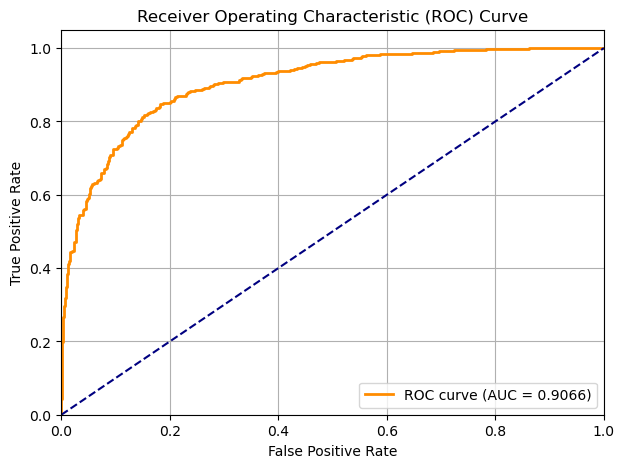

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
from PIL import Image

class SARImageDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, mode='train'):
        self.df = data
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.df.iloc[idx]['id']}.png")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            label = self.df.iloc[idx]["ground_truth"]
            target = {
                'boxes': torch.tensor([[0, 0, 224, 224]], dtype=torch.float32),
                'labels': torch.tensor([label], dtype=torch.int64),
            }
            return image, target
        else:
            return image, self.df.iloc[idx]["id"]

    def __len__(self):
        return len(self.df)

train_csv_path = "train.csv"
test_csv_path = "test.csv"
solutions_csv_path = "solution.csv"
train_images_path = "dataset/train/images"
test_images_path = "dataset/val/images"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
solutions_df = pd.read_csv(solutions_csv_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SARImageDataset(train_df, train_images_path, transform=transform, mode='train')
test_dataset = SARImageDataset(test_df, test_images_path, transform=transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

def create_faster_rcnn(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_faster_rcnn(num_classes=2).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = GradScaler()

from tqdm import tqdm 

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with autocast():
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{train_loss / len(train_loader):.4f}"})

    print(f"Epoch {epoch+1}/{num_epochs} Completed | Average Loss: {train_loss / len(train_loader):.4f}")
    scheduler.step()

model.eval()
predictions, image_ids, probs = [], [], []

with torch.no_grad():
    for images, ids in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, img_id in zip(outputs, ids):
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()

            if len(scores) > 0:
                best_idx = np.argmax(scores)
                predictions.append(labels[best_idx])
                probs.append(scores[best_idx])
            else:
                predictions.append(0)
                probs.append(0.0)

            image_ids.append(img_id)

solutions_df["id"] = solutions_df["id"].astype(str)
predictions_df = pd.DataFrame({
    "id": image_ids,
    "prediction": predictions,
    "probability": probs
})
predictions_df["id"] = predictions_df["id"].astype(str)

merged_df = pd.merge(predictions_df, solutions_df, on="id")

y_true = merged_df["ground_truth"]
y_pred = merged_df["prediction"]
y_prob = merged_df["probability"]

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1-Score:", f1_score(y_true, y_pred, average="macro"))

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class SARImageDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, mode='train'):
        self.df = data
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.df.iloc[idx]['id']}.png")
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            boxes = self.df.iloc[idx]["bounding_boxes"]  # List of [xmin, ymin, xmax, ymax]
            labels = self.df.iloc[idx]["ground_truth"]   # Class labels (1 for internal wave)

            target = {
                'boxes': torch.tensor(boxes, dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64),
            }
            return image, target
        else:
            return image, self.df.iloc[idx]["id"]

    def __len__(self):
        return len(self.df)


In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
solutions_df = pd.read_csv("solution.csv")

# Augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = SARImageDataset(train_df, "dataset/train/images", transform=transform, mode='train')
test_dataset = SARImageDataset(test_df, "dataset/val/images", transform=transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))


In [8]:
def create_faster_rcnn(num_classes):
    weights = models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    # Freeze backbone layers
    for param in model.backbone.parameters():
        param.requires_grad = False

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_faster_rcnn(num_classes=2).to(device)


In [9]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=3e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_loader), epochs=10)
scaler = GradScaler()


In [10]:
from tqdm import tqdm

num_epochs = 10
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with autocast():
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{total_loss / len(train_loader):.4f}"})

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/10:   0%|                                                                              | 0/567 [00:00<?, ?it/s]


KeyError: 'bounding_boxes'